In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm #formally known as pyramid-arima

In [3]:
import warnings
warnings.simplefilter(action= 'ignore', category= FutureWarning)

### Load and Prep Data

In [4]:
base_dir = '..\\data\\'

pickles = ['df_sj.pkl', 'df_iq.pkl',
           'sj_bayes.pkl', 'iq_bayes.pkl']

with open(base_dir + pickles[0],'rb') as f:
    sj = pickle.load(f)

sj_Y = sj['total_cases']

with open(base_dir + pickles[1],'rb') as f:
    iq = pickle.load(f)
    
iq_Y = iq['total_cases']
    
with open(base_dir + pickles[2],'rb') as f:
    sj_X = pickle.load(f)
    
with open(base_dir + pickles[3],'rb') as f:
    iq_X = pickle.load(f)
    
    
# the original samples all started on the first of the year, every year, 
# meaning different weekdays for the same yearly date. 
# Resampling to a uniform monthly set
iq_X = iq_X.drop(['year','weekofyear'],axis= 1).resample('MS').sum()
sj_X = sj_X.drop(['year','weekofyear'],axis= 1).resample('MS').sum()
iq_Y = iq_Y.resample('MS').sum()
sj_Y = sj_Y.resample('MS').sum()

In [5]:
iq_Xtrain, iq_Xtest, iq_Ytrain, iq_Ytest = pm.model_selection.train_test_split(iq_X, iq_Y, train_size= 0.75)
sj_Xtrain, sj_Xtest, sj_Ytrain, sj_Ytest = pm.model_selection.train_test_split(sj_X, sj_Y, train_size= 0.75)

In [6]:
def rmsle(ytrue, ypred):
    y = ytrue.to_numpy() if isinstance(ytrue, pd.DataFrame) else ytrue
    return np.mean(np.sqrt((np.power(np.log1p(ypred) - np.log1p(y), 2))/(len(y))))

def getscores(ytrue, ypred, log=False):
    """Print RMSE, MAE, R^2 scores"""
    scores = {}
    scores['MAE'] = mean_absolute_error(ytrue, ypred)
    if log is False:
        scores['RMSE'] = mean_squared_error(ytrue, ypred, squared= False) 
    else:
        scores['RMSLE'] = rmsle(ytrue, ypred)
    scores['SMAPE'] = pm.metrics.smape(ytrue, ypred)/100
        
    return scores

### ACF

In [7]:
def plotacf(ts):
    ax1 = plt.subplot(211)
    sm.graphics.tsa.plot_acf(ts.values, title= 'Autocorrelation', ax= ax1)
    ax2 = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(ts.values, title= 'Partial Autocorrelation', ax= ax2)
    plt.tight_layout()

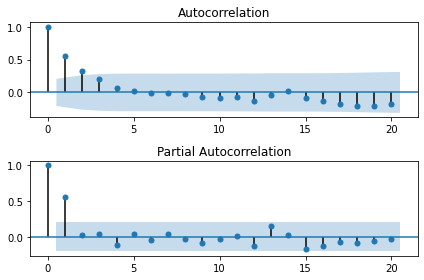

In [8]:
# IQ
plotacf(iq_Ytrain)

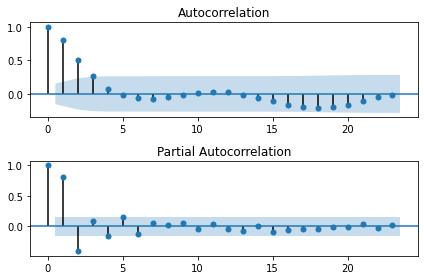

In [9]:
# SJ
plotacf(sj_Ytrain)

### Decomposition

In [10]:
def decompose(ts, plot=True, getcomp= False, model= 'additive', period= 12, side= False):
    decomposition = sm.tsa.seasonal_decompose(ts, model= model, period= period, two_sided= side)
    if plot:
        fig = plt.figure()
        fig = decomposition.plot()
        fig.set_size_inches(12,8)
        if getcomp:
            return decomposition

<Figure size 432x288 with 0 Axes>

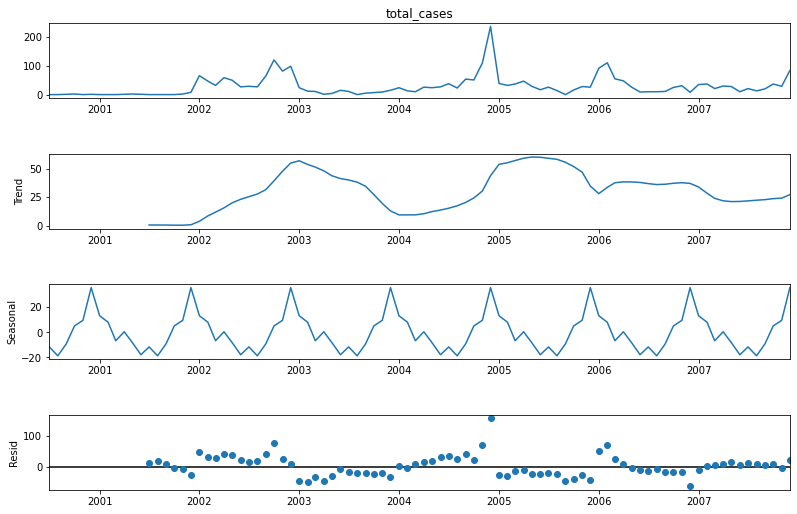

In [11]:
# IQ
decompose(iq_Ytrain)

<Figure size 432x288 with 0 Axes>

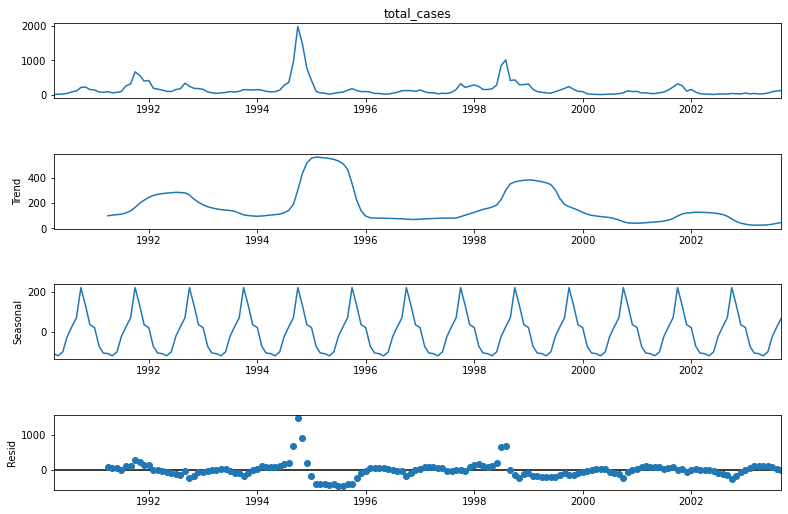

In [12]:
# SJ
decompose(sj_Ytrain)

### Stationarity testing

(Weak) Stationarity is defined as:
* Constant mean
* Constant variance
* Constant covariance

In [13]:
# adfuller test
def getadfuller(timeseries):
    adflabels = ['Test Statistic','p-value','#Lags Used','#Obs Used','critical values: ']
    adftest = sm.tsa.stattools.adfuller(timeseries, autolag= 'AIC')
    for i in range(len(adflabels) -1):
        print(adflabels[i], '\t', adftest[i])
    print(adflabels[-1])
    for key, value in adftest[-2].items():
        print('\t{}\t{}'.format(key,value))

In [14]:
def getkpss(timeseries):
    kpsslabels = ['Test Statistic','p-value','#Lags Used','critical values: ']
    kpss_test = sm.tsa.stattools.kpss(timeseries.values, regression= 'ct', nlags= 'auto')
    for i in range(len(kpsslabels) -1):
        print(kpsslabels[i], '\t', kpss_test[i])
    print(kpsslabels[-1])
    for key, value in kpss_test[-1].items():
        print('\t{}\t{}'.format(key,value))

###### Iquitos

In [15]:
print('IQ ADF:')
getadfuller(iq_Ytrain)
print('\nIQ KPSS:')
getkpss(iq_Ytrain)

IQ ADF:
Test Statistic 	 -4.794249045751583
p-value 	 5.578049296249617e-05
#Lags Used 	 0
#Obs Used 	 89
critical values: 
	1%	-3.506057133647011
	5%	-2.8946066061911946
	10%	-2.5844100201994697

IQ KPSS:
Test Statistic 	 0.09684234872406615
p-value 	 0.1
#Lags Used 	 4
critical values: 
	10%	0.119
	5%	0.146
	2.5%	0.176
	1%	0.216


C:\Users\Marko\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


###### San Juan

In [16]:
print('SJ ADF:')
getadfuller(sj_Ytrain)
print('\nSJ KPSS:')
getkpss(sj_Ytrain)

SJ ADF:
Test Statistic 	 -4.288192961370191
p-value 	 0.0004655966743325583
#Lags Used 	 4
#Obs Used 	 157
critical values: 
	1%	-3.472703119504854
	5%	-2.880131672353732
	10%	-2.5766826861130268

SJ KPSS:
Test Statistic 	 0.06587769139516257
p-value 	 0.1
#Lags Used 	 7
critical values: 
	10%	0.119
	5%	0.146
	2.5%	0.176
	1%	0.216


C:\Users\Marko\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


* Adjusted Dickie-Fuller test for unit roots shows a p-value for the null hypothesis < 5%, rejecting the hypothesis that the time series has unit roots, suggesting the series may be stationary.

* The KPSS test checks for trend stationarity. H_0 and H_A are opposite to the ADF test. With a low test statistic and large p-value, we can would reject the null typothesis of the kpss test that the time series is trend stationary.

* There is clear seasonality and trend seen in the decomposition above, that already tells us that the time series are not stationary and the statistical tests confirm that. Statsmodels provides an example of the results of our tests, and suggests differencing is to be used to make series stationary.

### Feature selecting

In [17]:
# Some researching shows that rainfall, tempurature, and humidity plays a roll
# in the activity and life cycle of mosquitos
# I chose not to use the month dummy variables as symptoms could take 2 weeks to appear and could extend into the next month
# I also chose not to include features that were too similar, eg. reanalysis avg temp AND station avg temp
relevant = ['precipitation_amt_mm', 'reanalysis_relative_humidity_percent',
          'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
          'station_min_temp_c']

iq_relevant = iq_Xtrain[relevant]
sj_relevant = sj_Xtrain[relevant]

In [18]:
# print("San Juan: ")
# display(sj_relevant.head(3).T)
# print("Iquitos: ")
# display(iq_relevant.head(3).T)

* Different features could be more significant between the two cities. Using the `tsfresh` package, I was able to extract a different set of features for each city based on the testing criteria used. I will use my defined feature set here.
* `tsfresh` also allows you to do feature extraction from your time series, which I decided I wouldn't use for reasons explained later.

#### Rolling window

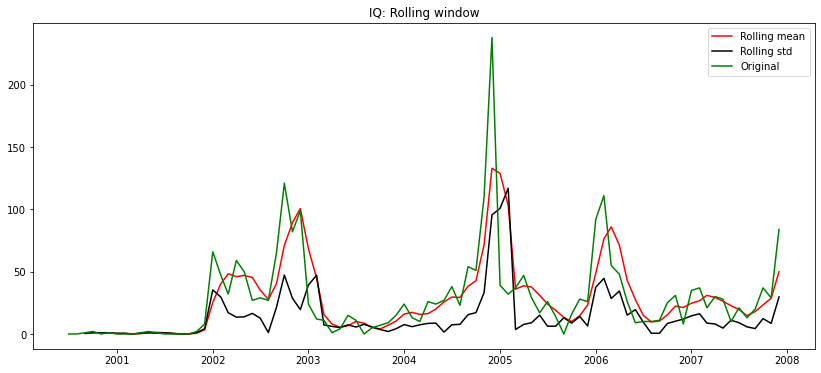

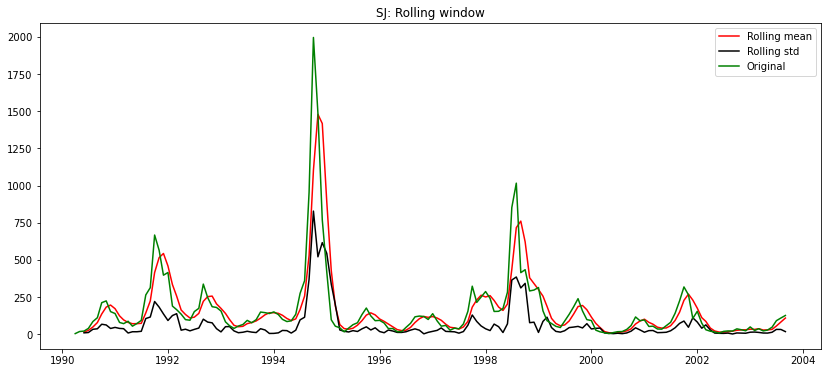

In [19]:
def roll(ts, window= 3):
    rollingmean = ts.rolling(window= window).mean()
    rollingstd = ts.rolling(window= window).std()
    return rollingmean, rollingstd

def drawrolls(roll, ts= None, std= True):
    
    rollmean = roll[0]
    fig, ax = plt.subplots(figsize= (14,6))
    ax.plot(rollmean, label= 'Rolling mean', c= 'r')
    if std:
        rollstd = roll[1]
        ax.plot(rollstd, label= 'Rolling std', c= 'k')
    if ts is not None:
        ax.plot(ts, label= 'Original', c= 'g')
    plt.legend()
     

drawrolls(roll(iq_Ytrain), iq_Ytrain)
plt.title("IQ: Rolling window")
drawrolls(roll(sj_Ytrain), sj_Ytrain)
plt.title("SJ: Rolling window");

In [20]:
# perform first difference on our training set 
iq_Ydiff = iq_Ytrain.diff().dropna()
sj_Ydiff = sj_Ytrain.diff().dropna()

#### Holt-Winter's Exponential Smoothing

In [21]:
# Comparing the Exponential smoothing on differenced series with and without damping the trend
def expSmooth(ts_train, ts_test, showtrain= True):
    model = sm.tsa.ExponentialSmoothing(ts_train, trend= 'add', seasonal= 'add', seasonal_periods= 12)
    fit = model.fit(optimized= True)
    pred = fit.forecast(len(ts_test))
    
    fig, ax = plt.subplots(figsize= (8, 5))
    if showtrain:
        ax.plot(ts_train.index, ts_train.values, label= 'Train')
    ax.plot(ts_test.index, ts_test.values, label= 'True Values', c= 'r', alpha= 0.4)
    ax.plot(ts_test.index, pred, linestyle= '--', color= 'g', label= "Predictions")
    ax.legend();
    return pred

C:\Users\Marko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\Marko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


{'MAE': 40.709112279423955,
 'RMSE': 64.4340037039544,
 'SMAPE': 1.2247466227994668}

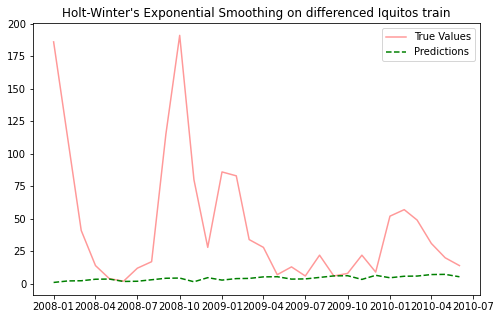

In [22]:
iq_smooth_pred = expSmooth(iq_Ydiff, iq_Ytest, showtrain= False)
plt.title("Holt-Winter's Exponential Smoothing on differenced Iquitos train");
display(getscores(iq_Ytest, iq_smooth_pred))

C:\Users\Marko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\Marko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


{'MAE': 95.58522411162647,
 'RMSE': 139.254913228267,
 'SMAPE': 1.400384375263567}

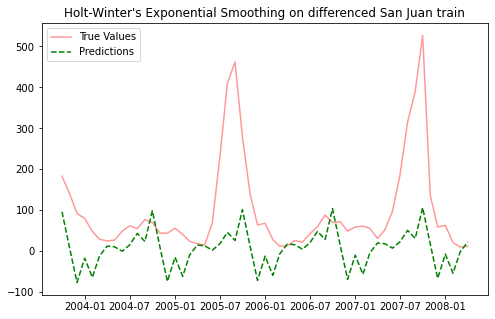

In [23]:
sj_smooth_pred = expSmooth(sj_Ydiff, sj_Ytest, showtrain= False)
plt.title("Holt-Winter's Exponential Smoothing on differenced San Juan train");
display(getscores(sj_Ytest, sj_smooth_pred))

* It seems `expSmooth` on the Iquitos series is far too smoothed to be of any use, the larger number of cases forecasted is 5, obviously nowhere close to the real case numbers. The San Juan series smoothing produces a seasonal forecast but negative case numbers aren't possible, and it doesn't predict the case pattern or outbreaks at all.

* We are utilizing the pmdarima auto arima funcitonality to find the optimal order combinations, and differencing values. Manually testing different combinations of these, and trying many manual iterations doesn't reveal a big difference in results. 

## pmdarima autoarima

In [24]:
# Can be time consuming and resource intensive, adjust maxiter for smaller run.
# I had to model monthly instead of weekly as I was running out of memory.

def pmdARIMA(y, exog, seasonal= True, D= None, trace= False, test= 'kpss', maxiter= 30):
    model = pm.auto_arima(y = y,
                    exogenous= exog,
                    start_p= 1, start_q= 1,
                    max_p= 2,  max_q= 2, m= 12,
                    max_P= 3, D= D, max_Q= 3, 
                    suppress_warnings= True, 
                    seasonal= seasonal,
                    test= test,
                    maxiter= maxiter,
                    trend = 't')
    return model

In [25]:
# Limit the test set features to match those of the training set. 
iq_relevant_test = iq_Xtest[relevant]
sj_relevant_test = sj_Xtest[relevant]

In [59]:
# Plotting actual vs predicted
def plotTruePredicted(ytest, pred, ytrain= None, conf= None):
    
    fig, ax = plt.subplots(figsize= (12,6))
    if ytrain is not None:
        ax.plot(ytrain.iloc[-ytrain.shape[0] //2:], color= 'b', label= 'Training Data')
    ax.plot(ytest.index, pred, color= 'g', marker= 'o', label= 'Predictions')
    ax.plot(ytest, color= 'r', label= 'True Values')
    ax.set_ylabel('Case Numbers')
    plt.xticks(rotation= 45)
    if conf is not None:
        ax.fill_between(ytest.index, conf[:,0], conf[:,1],
               alpha= 0.3, color= 'orange', label= "Confidence Interval")

    ax.legend();

### Iquitos

In [63]:
# Iquitos pmdarima autoARIMA 
# >> Time Consuming
pm_iqmodel = pmdARIMA(iq_Ytrain, iq_relevant, D= 1)
# pm_iqmodel.get_params()

{'maxiter': 30,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 1, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': 't',
 'with_intercept': False}

In [28]:
pm_iqmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   90
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -384.631
Date:                              Sun, 20 Sep 2020   AIC                            791.263
Time:                                      22:19:44   BIC                            817.187
Sample:                                  07-01-2000   HQIC                           801.641
                                       - 12-01-2007                                         
Covariance Type:                                opg                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
drift                                    0.0274      0.059      0.466      0.641      -0.088       0.142
precipitation_amt_mm                    -0.0482      0.112     -0.429      0.668      -0.269       0.172
reanalysis_relative_humidity_percent     0.2756      0.380      0.725      0.468      -0.469       1.020
station_avg_temp_c                       1.1544      5.435      0.212      0.832      -9.498      11.807
station_diur_temp_rng_c                 -1.9813      3.866     -0.512      0.608      -9.559       5.596
station_max_temp_c                       1.2464      3.407      0.366      0.714      -5.431       7.923
station_min_temp_c                      -2.1487      4.015     -0.535      0.593     -10.018       5.721
ar.L1                                    0.4954      0.070      7.058      0.000       0.358       0.633
ar.S.L12                                -0.2728      0.201     -1.359      0.174      -0.666       0.121
ma.S.L12                                -0.7437      0.210     -3.537      0.000      -1.156      -0.332
sigma2                                 981.6171    140.966      6.963      0.000     705.329    1257.906
===================================================================================
Ljung-Box (Q):                       22.85   Jarque-Bera (JB):               186.13
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             1.24
Prob(H) (two-sided):                  0.86   Kurtosis:                        10.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
iq_pred, iq_conf = pm_iqmodel.predict(n_periods=len(iq_Ytest), exogenous= iq_relevant_test, return_conf_int=True)
print("Iquitos metrics:")
display(getscores(iq_Ytest, iq_pred))

Iquitos metrics:


{'MAE': 36.75285510319384,
 'RMSE': 49.019425883506216,
 'SMAPE': 0.8352089860090574}

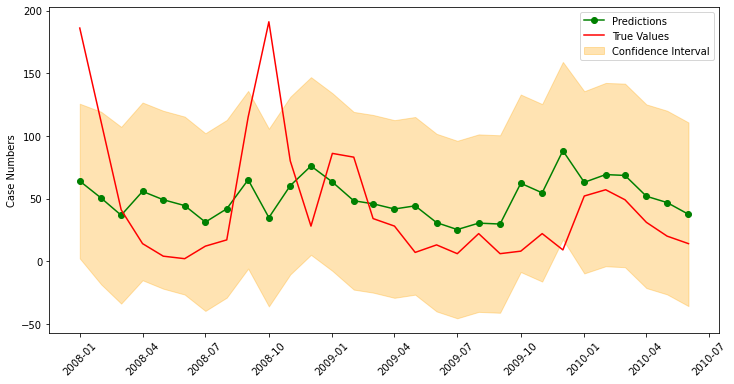

In [60]:
# Iquitos pmdarima predictions
plotTruePredicted(iq_Ytest, iq_pred, conf= iq_conf)

### San Juan

In [64]:
pm_sjmodel = pmdARIMA(sj_Ytrain, sj_relevant)
# pm_sjmodel.get_params()

{'maxiter': 30,
 'method': 'lbfgs',
 'order': (2, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': 't',
 'with_intercept': False}

In [32]:
pm_sjmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  162
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1011.671
Date:                Sun, 20 Sep 2020   AIC                           2043.341
Time:                        22:19:50   BIC                           2074.217
Sample:                    04-01-1990   HQIC                          2055.878
                         - 09-01-2003                                         
Covariance Type:                  opg                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
drift                                   -0.0717      0.291     -0.247      0.805      -0.642       0.498
precipitation_amt_mm                     0.0698      0.134      0.521      0.603      -0.193       0.333
reanalysis_relative_humidity_percent    -1.7244      1.538     -1.122      0.262      -4.738       1.289
station_avg_temp_c                     -19.9254     11.135     -1.789      0.074     -41.749       1.898
station_diur_temp_rng_c                  1.8479      8.985      0.206      0.837     -15.762      19.458
station_max_temp_c                      11.6992      6.343      1.844      0.065      -0.733      24.132
station_min_temp_c                      14.7145     10.997      1.338      0.181      -6.839      36.268
ar.L1                                    1.1832      0.042     28.032      0.000       1.100       1.266
ar.L2                                   -0.4829      0.061     -7.975      0.000      -0.602      -0.364
sigma2                                1.597e+04   1350.103     11.832      0.000    1.33e+04    1.86e+04
===================================================================================
Ljung-Box (Q):                       28.94   Jarque-Bera (JB):              2568.84
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
sj_pred, sj_conf = pm_sjmodel.predict(n_periods= len(sj_Ytest), exogenous= sj_relevant_test, return_conf_int= True)
print("San Juan metrics:")
display(getscores(sj_Ytest, sj_pred))

San Juan metrics:


{'MAE': 95.17157131431433,
 'RMSE': 119.31216848457376,
 'SMAPE': 0.8251286262863397}

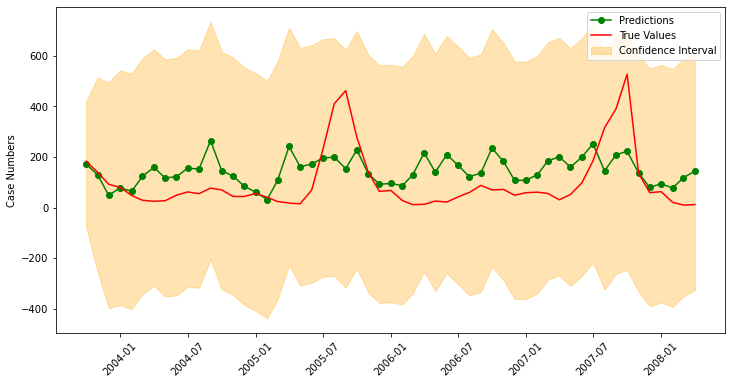

In [65]:
# San Juan
plotTruePredicted(sj_Ytest, sj_pred, conf= sj_conf)

Our metics aren't amazing for these models, there is some more to do on them, see below. 

* The predictions for Iquitos roughly match up to the true case numbers but are failing to predict to the magnitude seen in the outbreak periods. The predictions overall trending with the actual numbers.

* San Juan predictions are more invariable to the actual case numbers, and seem to stay around a leared mean of case numbers, fluctuating with the exogenous features.

# Notes

* One thing to point out is that I used a multi-step prediction, predicting the full length of our testing set, about 2.5 years of cases for Iquitos, and about 5 years of predictions for San Juan. 
    - I don't think this is best approach as you aren't retraining your model on new data. We aren't allowing for changes in our learned pattern of case numbers or climate changes.
    - In most cases, I'd chose to forecast stepwise in periods; annual or semi-annual in this case or an appropriate frequency depending on data. Retraining on the new data allows for the model to fit new changes accordingly.

* The feature importance, for feature selection, may change, and we might choose to adjust our model if we get a large amount of new training data. Though in the case of climate data, I wouldn't think there would be a huge change in a short time unless something big happens like a natural disaster. This depends on what you are modeling and frequency.

* Reported around the same time as the outbreaks in San Juan and Iquitos, natural disasters (hurricanes, floods, droughts,...), societal issues (wealth, development failures), human interference, and other external factors are of great influence to the case numbers and play a major part in both mosquito ecology and the capability for society to prevent dengue.